# FinQA — Hallucination Detection via Uncertainty Quantification
**Part A | Owners: Ayan Khan & Anum Khan**

This notebook walks through three UQ methods to detect hallucinations in financial reasoning:
1. **Self-Consistency** — sample N answers, measure agreement
2. **LogProb Entropy** — measure token-level uncertainty via logprobs
3. **Verbalized Confidence** — ask the model to self-report confidence

Then we check: *does high confidence actually correlate with correctness?*

## 0. Setup

In [2]:
# Run once to install dependencies
%pip install openai datasets pandas matplotlib -q
%pip install -U "huggingface_hub>=0.24.5"


[notice] A new release of pip is available: 25.1.1 -> 26.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 25.1.1 -> 26.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
import os, re, math, json, time
from typing import Any, Dict, List, Optional

import pandas as pd
import matplotlib.pyplot as plt

from LLM_utils import (
    LLMConfig, LLMRequest, SimpleDiskCache, 
    generate, self_consistency_samples, simple_majority_vote,
    build_finqa_prompt, parse_json_answer, append_jsonl, DEFAULT_SYSTEM,
    make_delimited_prompt, with_retries
)

print('Imports OK')

Imports OK


In [5]:
# Config
from dotenv import load_dotenv
load_dotenv()  # loads .env into os.environ automatically

HF_API_KEY = os.getenv('HF_API_KEY')  
OPENAI_API_KEY = os.getenv('OPENAI_API_KEY')

MODELS: Dict[str, LLMConfig] = {
    # Free HuggingFace Inference API models
    'mistral-7b':  LLMConfig(provider='huggingface', model='mistralai/Mistral-7B-Instruct-v0.3', temperature=0.2, max_tokens=512),
    'llama-3':     LLMConfig(provider='huggingface', model='meta-llama/Meta-Llama-3-8B-Instruct', temperature=0.2, max_tokens=512),
    'mock':        LLMConfig(provider='mock',        model='mock', temperature=0.2, max_tokens=512),
}

SELECTED_MODELS = ['mistral-7b', 'mock']  # ← swap / add models here
MAX_ROWS        = 10    # number of FinQA examples to evaluate
N_SC_SAMPLES    = 5     # self-consistency samples per example
RESULTS_PATH    = 'runs/exploration_results.jsonl'
CACHE_PATH      = 'runs/llm_cache.jsonl'

cache = SimpleDiskCache(CACHE_PATH)
print('Config ready')

ModuleNotFoundError: No module named 'dotenv'

## 1. Load Data

In [7]:
def load_data(split: str = 'test', max_rows: int = 10) -> List[Dict]:
    path = f'data/finQA/{split}.json' # Load data from local finQA dataset

    with open(path, 'r') as f:
        raw = json.load(f)

    rows = []
    for i, ex in enumerate(raw[:max_rows]):
        pre   = ' '.join(ex.get('pre_text',  []) or [])
        post  = ' '.join(ex.get('post_text', []) or [])
        table = '\n'.join(' | '.join(str(c) for c in r) for r in (ex.get('table') or []))
        rows.append({
            'id':          ex.get('id', f'{split}_{i}'),
            'split':       split,
            'question':    ex['qa']['question'],
            'context':     f'{pre}\n\nTable:\n{table}\n\n{post}'.strip(),
            'gold_answer': str(ex['qa']['answer']),
        })

    print(f'Loaded {len(rows)} rows from {path}')
    return rows

rows = load_data(split='test', max_rows=MAX_ROWS)
pd.DataFrame(rows)[['id', 'question', 'gold_answer']].head()

NameError: name 'MAX_ROWS' is not defined

## 2. UQ Methods

In [8]:
# Method 1: Self-Consistency
"""
Core idea: ask the model the same question N times and see if it keeps giving the same answer. 
High agreement = high confidence. 
Disagreement = likely hallucinating.
"""

def uq_self_consistency(system, user, cfg, n=5, cache=None):
    # return agreement ratio as confidence
    samples = self_consistency_samples(system, user, cfg, n=n, cache=cache)
    answers = [str(parse_json_answer(s.text).get('final_answer', '')).strip() for s in samples]
    majority, counts = simple_majority_vote(answers)
    return {
        'method':          'self_consistency',
        'confidence':      round(counts.get(majority, 0) / max(len(answers), 1), 4),
        'majority_answer': majority,
        'vote_counts':     counts,
    }

print('Self-Consistency defined')

Self-Consistency defined


In [9]:
# Quick test — uses mock provider so no API calls
test_cfg    = MODELS['mock']
test_row    = rows[0]
test_user   = build_finqa_prompt(test_row['context'], test_row['question'])
test_result = uq_self_consistency(DEFAULT_SYSTEM, test_user, test_cfg, n=3, cache=None)

print(f"Method:     {test_result['method']}")
print(f"Confidence: {test_result['confidence']}")
print(f"Answer:     {test_result['majority_answer']}")
print(f"Votes:      {test_result['vote_counts']}")

NameError: name 'MODELS' is not defined

In [10]:
def uq_logprob_entropy(system, user, cfg, cache=None):
    """
    Core idea: Instead of asking the model multiple times, we look inside a single response at 
    how certain the model was about each word it chose. 
    High certainty per word = high confidence.
    """
    if cfg.provider != 'openai':
        return {'method': 'logprob_entropy', 'confidence': None, 'mean_entropy': None}
    try:
        from openai import OpenAI
        client = OpenAI()

        def _call():
            return client.chat.completions.create(
                model=cfg.model,
                messages=[{'role': 'system', 'content': system}, {'role': 'user', 'content': user}],
                temperature=0.0, max_tokens=cfg.max_tokens, logprobs=True, top_logprobs=5,
            )

        resp    = with_retries(_call, max_retries=cfg.max_retries)  # from LLM_utils
        lp_data = resp.choices[0].logprobs.content or []
        entropies = []
        for tok in lp_data:
            probs = [math.exp(t.logprob) for t in (tok.top_logprobs or [])]
            if probs:
                total = sum(probs)
                probs = [p / total for p in probs]
                entropies.append(-sum(p * math.log(p + 1e-12) for p in probs))
        mean_h = sum(entropies) / len(entropies) if entropies else None
        return {
            'method':       'logprob_entropy',
            'mean_entropy': round(mean_h, 6) if mean_h else None,
            'confidence':   round(1.0 - mean_h / math.log(5), 4) if mean_h else None,
        }
    except Exception as e:
        return {'method': 'logprob_entropy', 'confidence': None, 'mean_entropy': None, 'error': str(e)}

print('LogProb Entropy defined')

LogProb Entropy defined


In [11]:
# Test — logprob entropy returns None for non-openai providers (expected)
test_cfg = MODELS['mock']
test_row = rows[0]
test_user = build_finqa_prompt(test_row['context'], test_row['question'])

test_result = uq_logprob_entropy(DEFAULT_SYSTEM, test_user, test_cfg)

print(f"Method:       {test_result['method']}")
print(f"Confidence:   {test_result['confidence']}")   # expect None — mock isn't openai
print(f"Mean Entropy: {test_result['mean_entropy']}") # expect None
print(f"Note: returns None for non-OpenAI providers")

NameError: name 'MODELS' is not defined

In [12]:
# Method 3: Verbalized Confidence
def uq_verbalized_confidence(context, question, cfg, cache=None):
    """Core idea: just ask the model how confident it is. """
    task = (
        'Solve the financial question step-by-step.\n'
        'Output ONLY this JSON on the last line (no extra keys):\n'
        '{"final_answer": "...", "confidence_pct": <0-100>, "reasoning": "..."}'
    )
    user_prompt = make_delimited_prompt(task, f'CONTEXT:\n{context}\n\nQUESTION:\n{question}')
    req  = LLMRequest(system='You are a careful financial reasoning assistant.',
                      user=user_prompt, meta={'uq': 'verbalized'}, config=cfg)
    resp = generate(req, cache=cache)
    parsed   = parse_json_answer(resp.text)
    conf_raw = parsed.get('confidence_pct')
    return {
        'method':       'verbalized_confidence',
        'confidence':   round(float(conf_raw) / 100.0, 4) if conf_raw is not None else None,
        'final_answer': str(parsed.get('final_answer', '')).strip(),
    }

print('Verbalized Confidence defined')

Verbalized Confidence defined


In [13]:
# Test — verbalized confidence
test_cfg  = MODELS['mock']
test_row  = rows[0]

test_result = uq_verbalized_confidence(test_row['context'], test_row['question'], test_cfg, cache=None)

print(f"Method:       {test_result['method']}")
print(f"Confidence:   {test_result['confidence']}")    # None — mock returns plain string, not valid JSON with confidence_pct
print(f"Final Answer: {test_result['final_answer']}")  # None — same reason
print(f"Note: mock doesn't return confidence_pct field")

NameError: name 'MODELS' is not defined

## 3. Run Pipeline

In [14]:
def is_correct(predicted: str, gold: str) -> bool:
    # Fuzzy match: strips white space,symbols,lowercase then compares .
    def norm(s):
        return re.sub(r'[\s\$,%]+', '', s.lower().strip())
    p, g = norm(predicted), norm(gold)
    return p == g or g in p or p in g

def run_example(row, model_name, cfg, n_sc=5, cache=None):
    #Run all three UQ methods on one FinQA example.
    user_prompt = build_finqa_prompt(row['context'], row['question'])

    # Baseline greedy answer
    baseline = generate(
        LLMRequest(system=DEFAULT_SYSTEM, user=user_prompt,
                   meta={'id': row['id'], 'model': model_name}, config=cfg),
        cache=cache
    )
    baseline_answer = str(parse_json_answer(baseline.text).get('final_answer', '')).strip()

    sc  = uq_self_consistency(DEFAULT_SYSTEM, user_prompt, cfg, n=n_sc, cache=cache)
    lpe = uq_logprob_entropy(DEFAULT_SYSTEM, user_prompt, cfg, cache=cache)
    vc  = uq_verbalized_confidence(row['context'], row['question'], cfg, cache=cache)

    return {
        'id': row['id'], 'model': model_name,
        'question': row['question'], 'gold': row['gold_answer'],
        'predicted': baseline_answer,
        'correct': is_correct(baseline_answer, row['gold_answer']),
        'sc_confidence':  sc['confidence'],
        'lpe_confidence': lpe.get('confidence'),
        'vc_confidence':  vc.get('confidence'),
        'vc_answer':      vc.get('final_answer'),
    }

print('Pipeline helpers defined')

Pipeline helpers defined


In [15]:
results = []

for model_name in SELECTED_MODELS:
    cfg = MODELS[model_name]
    print(f'\n=== {model_name} ({len(rows)} examples) ===')
    for row in rows:
        try:
            r = run_example(row, model_name, cfg, n_sc=N_SC_SAMPLES, cache=cache)
            results.append(r)
            append_jsonl(RESULTS_PATH, r)
            status = '✓' if r['correct'] else '✗'
            print(f"  {status} [{row['id']}] predicted={r['predicted']!r}  gold={row['gold_answer']!r}  sc={r['sc_confidence']}")
        except Exception as e:
            print(f"  [ERROR] {row['id']}: {e}")

df = pd.DataFrame(results)
print(f'\nDone. {len(df)} results saved to {RESULTS_PATH}')
df.head()

NameError: name 'SELECTED_MODELS' is not defined

## 4. Calibration Analysis
Key hypothesis: **high confidence → more likely correct**

In [16]:
THRESHOLD = 0.7
methods = [('sc_confidence', 'Self-Consistency'), ('lpe_confidence', 'LogProb Entropy'), ('vc_confidence', 'Verbalized Conf')]

rows_summary = []
for col, label in methods:
    sub = df.dropna(subset=[col])
    if sub.empty: continue
    hi = sub[sub[col] >= THRESHOLD]
    lo = sub[sub[col] <  THRESHOLD]
    rows_summary.append({
        'Method': label,
        'High-conf n': len(hi), 'High-conf acc': f"{hi['correct'].mean():.0%}" if len(hi) else 'N/A',
        'Low-conf n':  len(lo), 'Low-conf acc':  f"{lo['correct'].mean():.0%}" if len(lo) else 'N/A',
    })

pd.DataFrame(rows_summary).set_index('Method')

NameError: name 'df' is not defined

NameError: name 'df' is not defined

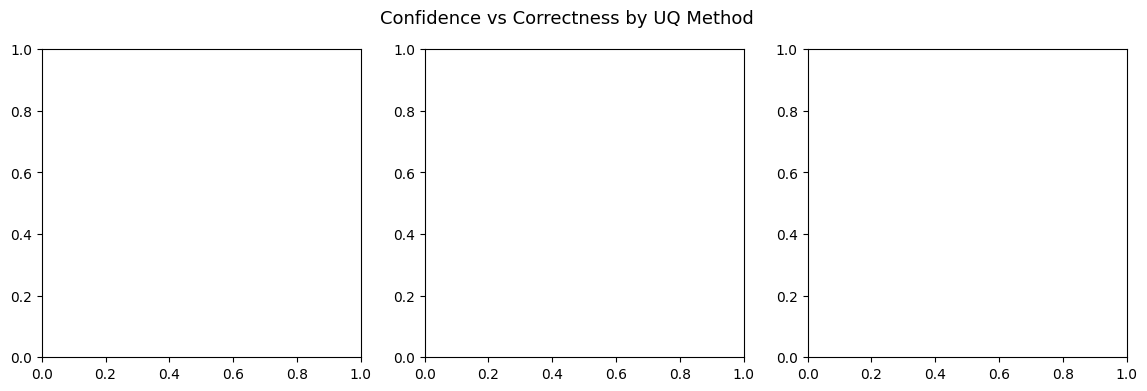

In [17]:
fig, axes = plt.subplots(1, 3, figsize=(14, 4))
fig.suptitle('Confidence vs Correctness by UQ Method', fontsize=13)

for ax, (col, label) in zip(axes, methods):
    sub = df.dropna(subset=[col])
    if sub.empty:
        ax.set_title(f'{label}\n(no data)')
        continue
    # Bin into 5 buckets, plot mean accuracy per bucket
    sub = sub.copy()
    sub['bin'] = pd.cut(sub[col], bins=5)
    grouped = sub.groupby('bin', observed=True)['correct'].mean()
    grouped.plot(kind='bar', ax=ax, color='steelblue', edgecolor='white')
    ax.set_title(label)
    ax.set_xlabel('Confidence bucket')
    ax.set_ylabel('Accuracy')
    ax.set_ylim(0, 1.05)
    ax.tick_params(axis='x', rotation=30)

plt.tight_layout()
plt.savefig('runs/calibration_plot.png', dpi=120)
plt.show()